In [1]:
# -*- coding: utf-8 -*-

from sklearn.linear_model import LogisticRegression
import argparse
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


from azureml.core.run import Run
from azureml.data.dataset_factory import TabularDatasetFactory


In [2]:
df= pd.read_csv("https://raw.githubusercontent.com/srees1988/predict-churn-py/main/customer_churn_data.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df['customerID'].nunique() == df.shape[0]

True

In [5]:
df.drop('customerID', axis=1, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
def clean_data(df):
    
    # replace blanks with np.nan
    df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
    # convert to float64
    df['TotalCharges'] = df['TotalCharges'].astype('float64')
    
    # Replace binary values
    df['gender'] = df['gender'].apply(lambda s: 1 if s == "Female" else 0)
    df['Partner'] = df['Partner'].apply(lambda s: 1 if s == "Yes" else 0)
    df['Dependents'] = df['Dependents'].apply(lambda s: 1 if s == "Yes" else 0)
    df['PhoneService'] = df['PhoneService'].apply(lambda s: 1 if s == "Yes" else 0)
    df['PaperlessBilling'] = df['PaperlessBilling'].apply(lambda s: 1 if s == "Yes" else 0)
    df['Churn'] = df['Churn'].apply(lambda s: 1 if s == "Yes" else 0)

    MultipleLines = pd.get_dummies(df['MultipleLines'], prefix="MultipleLines")
    df.drop("MultipleLines", inplace=True, axis=1)
    df = df.join(MultipleLines)
    InternetService = pd.get_dummies(df['InternetService'], prefix="InternetService")
    df.drop("InternetService", inplace=True, axis=1)
    df = df.join(InternetService)
    OnlineSecurity = pd.get_dummies(df['OnlineSecurity'], prefix="OnlineSecurity")
    df.drop("OnlineSecurity", inplace=True, axis=1)
    df = df.join(OnlineSecurity)
    OnlineBackup = pd.get_dummies(df['OnlineBackup'], prefix="OnlineBackup")
    df.drop("OnlineBackup", inplace=True, axis=1)
    df = df.join(OnlineBackup)
    DeviceProtection = pd.get_dummies(df['DeviceProtection'], prefix="DeviceProtection")
    df.drop("DeviceProtection", inplace=True, axis=1)
    df = df.join(DeviceProtection)
    TechSupport = pd.get_dummies(df['TechSupport'], prefix="TechSupport")
    df.drop("TechSupport", inplace=True, axis=1)
    df = df.join(TechSupport)
    StreamingTV = pd.get_dummies(df['StreamingTV'], prefix="StreamingTV")
    df.drop("StreamingTV", inplace=True, axis=1)
    df = df.join(StreamingTV)
    StreamingMovies = pd.get_dummies(df['StreamingMovies'], prefix="StreamingMovies")
    df.drop("StreamingMovies", inplace=True, axis=1)
    df = df.join(StreamingMovies)
    Contract = pd.get_dummies(df['Contract'], prefix="Contract")
    df.drop("Contract", inplace=True, axis=1)
    df = df.join(Contract)
    PaymentMethod = pd.get_dummies(df['PaymentMethod'], prefix="PaymentMethod")
    df.drop("PaymentMethod", inplace=True, axis=1)
    df = df.join(PaymentMethod)
    y_df = df.pop('Churn')
    # x_df = df.drop("Churn", inplace=True, axis=1)

    return df, y_df

x, y = clean_data(df)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [8]:
# fit model no training data
model = XGBClassifier()
eval_set = [(x_test, y_test)]
model.fit(x_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.2044
[1]	validation_0-error:0.203691
[2]	validation_0-error:0.20511
[3]	validation_0-error:0.203691
[4]	validation_0-error:0.20511
[5]	validation_0-error:0.203691
[6]	validation_0-error:0.2044
[7]	validation_0-error:0.203691
[8]	validation_0-error:0.203691
[9]	validation_0-error:0.203691
[10]	validation_0-error:0.202271
[11]	validation_0-error:0.201561
[12]	validation_0-error:0.199432
[13]	validation_0-error:0.198722
[14]	validation_0-error:0.198013
[15]	validation_0-error:0.200142
[16]	validation_0-error:0.198722
[17]	validation_0-error:0.198722
[18]	validation_0-error:0.197303
[19]	validation_0-error:0.198013
[20]	validation_0-error:0.195174
[21]	validation_0-error:0.195884
[22]	validation_0-error:0.192335
[23]	validation_0-error:0.190916
[24]	validation_0-error:0.192335
[25]	validation_0-error:0.194464
[26]	validation_0-error:0.191625
[27]	validation_0-error:0.191625
[28]	validation_0-error:0.189496
[29]	validation_0-error:0.188077
[30]	validation_0-error:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

[0]	validation_0-error:0.19010	validation_0-logloss:0.57174	validation_1-error:0.19588	validation_1-logloss:0.57446
[1]	validation_0-error:0.18317	validation_0-logloss:0.50304	validation_1-error:0.20298	validation_1-logloss:0.51076


/home/vhcg77/anaconda3/envs/hyperdrive/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-error:0.17625	validation_0-logloss:0.45912	validation_1-error:0.19517	validation_1-logloss:0.47184
[3]	validation_0-error:0.17412	validation_0-logloss:0.42974	validation_1-error:0.19517	validation_1-logloss:0.44826
[4]	validation_0-error:0.17128	validation_0-logloss:0.40770	validation_1-error:0.19234	validation_1-logloss:0.43216
[5]	validation_0-error:0.17110	validation_0-logloss:0.39246	validation_1-error:0.19375	validation_1-logloss:0.42265
[6]	validation_0-error:0.16986	validation_0-logloss:0.38033	validation_1-error:0.19234	validation_1-logloss:0.41401
[7]	validation_0-error:0.16720	validation_0-logloss:0.37066	validation_1-error:0.19446	validation_1-logloss:0.40810
[8]	validation_0-error:0.16507	validation_0-logloss:0.36357	validation_1-error:0.19588	validation_1-logloss:0.40616
[9]	validation_0-error:0.16489	validation_0-logloss:0.35761	validation_1-error:0.19943	validation_1-logloss:0.40498
[10]	validation_0-error:0.16170	validation_0-logloss:0.35311	validation_

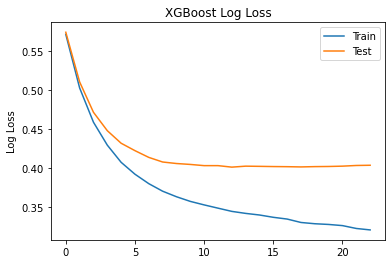

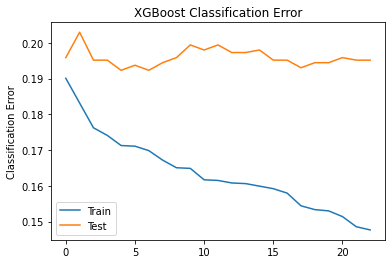

In [27]:
# plot learning curve
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
# load data

# fit model no training data
model = XGBClassifier()
eval_set = [(x_train, y_train), (x_test, y_test)]
# model.fit(x_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [41]:
x[x.columns[20]].value_counts().index.tolist()

[0, 1]

In [42]:
x.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
MultipleLines_No                             uint8
MultipleLines_No phone service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No                            uint8
OnlineSecurity_No internet service           uint8
OnlineSecurity_Yes                           uint8
OnlineBackup_No                              uint8
OnlineBackup_No internet servic

In [12]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

NameError: name 'predictions' is not defined

In [57]:
def GridSearchCV_XGB_early_stoppping(param_grid, fit_params, scorer, cv, X, y):
    """This function performs grid search for the best set of parameters of XGBoost model with early stopping.

    Args:
        param_grid (dict): The parameter ranges for which the function searches.
        fit_params (dict): The fitting parameters for XGBoost.
        scorer (_PredictScorer): The sklearn's scorer instance.
        cv (model_selection._split): The sklearn's split instance.
        X (DataFrame): The input data matrix.
        y (Series): The ground truth label.
        
    Returns:
        dict: The best set of parameters found via grid search.
    """
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()
        
    param_names, param_values = zip(*list(param_grid.items()))

    cv_best_iterations = defaultdict(list)
    cv_results = defaultdict(list)

    for train_index, test_index in cv.split(X, y):
        X_in, X_out = X[train_index], X[test_index]
        y_in, y_out = y[train_index], y[test_index]

        fit_params_cv = deepcopy(fit_params)
        fit_params_cv['eval_set'] = [(X_out, y_out)]

        for value_combination in product(*param_values):
            param_grid_cv = tuple(zip(param_names, value_combination))
            xgboost = XGBClassifier(**dict(param_grid_cv))

            xgboost.fit(X_in, y_in, **fit_params_cv)
            best_iteration = xgboost.get_num_boosting_rounds() if 'early_stopping_rounds' not in fit_params_cv else xgboost.best_iteration
            cv_best_iterations[param_grid_cv].append(best_iteration)

            score = scorer(xgboost, X_out, y_out)
            cv_results[param_grid_cv].append(score)
        
    best_params_xgb, score_list = max(cv_results.items(), key=lambda x: np.array(x[1]).mean())

    # Note that our XGBoost model may stop early,
    # so we calculate the mean of the actual number of estimators in each fold,
    # in place of the originally planned n_estimators after finishing cross validation.
    n_estimators = int(round(np.array(cv_best_iterations[best_params_xgb]).mean()))
    
    best_params_xgb = dict(best_params_xgb)
    best_params_xgb['n_estimators'] = n_estimators

    print ("Best score: {:.3f}".format(np.array(score_list).mean()))
    print ("Best Parameters: {}".format(best_params_xgb))
    
    return best_params_xgb

In [58]:
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import KFold
from collections import defaultdict
from copy import deepcopy
from itertools import product

seed = 0

param_grid = {
    'objective': ['binary:logistic'],
    'n_estimators': [200, 500, 1000, 1500, 2000],
    'max_depth': [2, 5, 10],
    'learning_rate': [0.001, 0.01, 0.1],
    'random_state': [seed]
}

fit_params = {
    'eval_metric': ["error", "logloss", "auc", "aucpr"],
    'early_stopping_rounds': 10,
    'verbose': False
}

scorer = make_scorer(accuracy_score, greater_is_better=False)
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

best_params_xgb = GridSearchCV_XGB_early_stoppping(param_grid, fit_params, scorer, kf, x_train, y_train)

best_xgb = XGBClassifier(**best_params_xgb)
best_xgb.fit(x_train, y_train, eval_metric=fit_params['eval_metric'], verbose=False)
best_score = scorer(best_xgb, x_test, y_test)
print ("The best score for XGBoost on validation set is {:.3f}".format(best_score))

# np.save('best_params_xgb.npy', best_params_xgb)

/home/vhcg77/anaconda3/envs/hyperdrive/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/vhcg77/anaconda3/envs/hyperdrive/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/vhcg77/anaconda3/envs/hyperdrive/lib/pyt

Best score: -0.748
Best Parameters: {'objective': 'binary:logistic', 'n_estimators': 0, 'max_depth': 2, 'learning_rate': 0.001, 'random_state': 0}
The best score for XGBoost on validation set is -0.735


/home/vhcg77/anaconda3/envs/hyperdrive/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
